# Random Forest Regression (RFR)

This notebook covers the impementation of a RFR model for load forecasting purposes.

The model is implemented using the Darts python package

Please pip install the requirements.txt file before running

Authors: Andreas Liiv, (Florian Kühn, Ali Kamran)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, holidays
from darts.models import RandomForest
from darts import TimeSeries
from darts.metrics import mape, mae, rmse
from datetime import timedelta
import joblib

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 22})

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def print_evaluation_metrics(actual,predicted):
    '''
    Evaluation function printing out the following error metrics:
     - Mean Absolute Percentage Error (MAPE): mainly used for classification of model accuracy
     - Mean Absolute Error (MAE): used for getting a physical interpretation of what the obtained error means (MW deviation)
     - Root Mean Squared Error (RMSE): used to measure how forecasts predict outliers: higher values mean worse outlier prediction
     - Days with maximum and minimum MAPE in the considered test range
     - Box plots using daily error metrics
     Darts error metrics functions were preferred over scikit-learn, as they handle extreme values better.

     Parameters:
        actual: measured load pandas series
        predicted: forecasted load pandas series
    
    Returns: Printed evaluation metrics and box plots
     
    '''
    
    # Compute MAPE
    actual_series = TimeSeries.from_series(actual)
    predicted_series = TimeSeries.from_series(predicted)

    mape_val = mape(actual_series, predicted_series)
    rmse_val = rmse(actual_series, predicted_series)
    mae_val = mae(actual_series, predicted_series)

    print(f"MAPE: {mape_val:.2f}%")
    print(f"RMSE: {rmse_val:.2f}")
    print(f"MAE: {mae_val:.2f}MW")

    # Combine into one DataFrame
    df = pd.DataFrame({
        'actual': actual,
        'predicted': predicted
    })
    df.index = pd.to_datetime(df.index)  # Ensure datetime index

    # Remove rows where actual == 0 to avoid division by zero
    df = df[df['actual'] != 0]

    # Add 'date' column for grouping
    df['date'] = df.index.date

    # Calculate absolute percentage error per row
    df['abs_pct_error'] = np.abs(df['actual'] - df['predicted']) / df['actual']

    # Group by date and calculate daily MAPE
    daily_mape = df.groupby('date')['abs_pct_error'].mean() * 100  # Convert to %

    max_mape_value = daily_mape.max()
    min_mape_value = daily_mape.min()
    max_mape_date = daily_mape.idxmax()
    min_mape_date = daily_mape.idxmin()

    print(f"Maximum MAPE: {max_mape_value:.2f}% on {max_mape_date}")
    print(f"Minimum MAPE: {min_mape_value:.2f}% on {min_mape_date}")

    # Plot boxplot 
    values = daily_mape.dropna().values
    plt.figure(figsize=(12, 6))
    plt.boxplot(values, vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='red'),
                whiskerprops=dict(color='gray'),
                capprops=dict(color='gray'),
                flierprops=dict(marker='o', markerfacecolor='gray', markersize=5, linestyle='none'))

    plt.ylabel("MAPE (%)")
    plt.title("Distribution of Daily MAPE")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
def plot_forecast(actual, predicted, model_name):
    '''
    Plot function printing the "actual" measured and "predicted" load sets.
    If "model_name" is given, saves the plot to a pdf file with that string as name.
    
    Parameters:
        actual: measured load series
        predicted: forecasted load series
        model_name: optional string to name model if it should be saved

    Returns: Plotted comparisons between forecasted and actual values
    '''
        
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual, label='Actual', linewidth=2)
    plt.plot(predicted.index, predicted, label='Predicted')
    plt.legend()
    plt.title('Load Forecast: Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Load (MW)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(model_name, format="pdf", bbox_inches="tight")
    plt.show()

In [3]:
def read_load_data():
    '''
    Reads load data from file 'processed_loadUTC_data.csv'. 
    Renames columns for better handling in future code.

    Returns: DataFrame containing load data
    '''
    
    base_dir = os.getcwd()
    load_file_path = os.path.join(base_dir, 'processed_loadUTC_data.csv')
    load_data = pd.read_csv(load_file_path)
    load_data.rename(columns={
        "Actual Total Load [MW] - BZN|SE4": "Actual Load",
        "Time (UTC)": "Time"
    }, inplace=True)
    load_data['Time'] = pd.to_datetime(load_data['Time'].str.split(' - ').str[0], format='%d.%m.%Y %H:%M')
    load_data.set_index('Time', inplace=True)
    load_data.drop('Day-ahead Total Load Forecast [MW] - BZN|SE4', axis=1, inplace=True)
    return load_data

data = read_load_data()

In [4]:
def import_weather_data(df, solar_power=False):
    '''
    The weighted averages of weather data (incl. temperature, humidity and solar irradiation) is read and added to the main dataframe.
    If "solar_power" is given as 'True', solar irradiation data is replaced by an estimate of total solar power generation.

    Parameters:
        df: pandas DataFrame
        solar_power: boolean for converting solar irradiation to solar power if 'True'
    
    Returns: input DataFrame appended with weather data
    '''

    # Read and store weather data into dataframe
    base_dir = os.getcwd()
    temperature_file_path = os.path.join(base_dir, 'weighted_avg_temp.csv')
    humidity_file_path = os.path.join(base_dir, 'weighted_avg_humidity.csv')
    solar_file_path = os.path.join(base_dir, 'weighted_avg_solar.csv')
    avg_temperature_data = pd.read_csv(temperature_file_path)
    avg_humidity_data = pd.read_csv(humidity_file_path)
    avg_solar_data = pd.read_csv(solar_file_path)
    df['Temperature'] = avg_temperature_data['weighted_avg'].values
    df['Humidity'] = avg_humidity_data['weighted_avg'].values
    df['Solar_Irrad'] = avg_solar_data['weighted_avg'].values
    
    # convert solar irradiation to solar power if needed
    if solar_power:
        tot_installed_capacity = np.array([2.52, 5.04, 7.56, 10.08, 12.6, 18.6, 29.2, 41.53, 69.55, 85])*1e6
        installed_capacity_house = 10*1e3
        n_installations = tot_installed_capacity / installed_capacity_house
        panel_per_house = 24
        area_per_panel = 2

        years = np.arange(2015, 2025)
        total_area_panels = n_installations * panel_per_house * area_per_panel
        area_by_year = dict(zip(years, total_area_panels))

        panel_efficiency = 0.2
        df['year'] = df.index.year
        df['Solar'] = df['Solar_Irrad'] * data['year'].map(area_by_year) * panel_efficiency
        df.drop(columns='year', inplace=True)
    else:
        df['Solar'] = df['Solar_Irrad']
    df.drop(columns='Solar_Irrad',inplace=True)
    return df

data = import_weather_data(data, solar_power=True)

In [5]:
def import_swedish_holidays(df):
    '''
    Imports Swedish holidays into column 'is_holiday' of input DataFrame
    
    Parameters:
        df: pandas Dataframe
    
    Returns: DataFrame appended with Swedish holidays
    '''
    years = np.arange(2015, 2025)
    raw_holidays = []
    for date, name in sorted(holidays.Sweden(years=years).items()):
        raw_holidays.append(date)
    holiday_dates = set(raw_holidays)
    df['is_holiday'] = pd.Series(df.index.date).isin(holiday_dates).astype(int).values
    return df

data = import_swedish_holidays(data)

In [6]:
def create_date_features(df):
    '''
    Creates date features marking the hour of the day, day of the week and a boolean with 
    value 'True' if a day is part of the weekend and 'False' otherwise.

    Parameters:
        df: pandas DataFrame
    
    Returns: DataFrame appended with hour, day of week and weekend boolean
    '''
    
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    return df

data = create_date_features(data)

In [7]:
def add_noise_to_covariates(df, noise_level: float = 0.05,seed: int=42):
    '''
    Adds Gaussian noise with set "noise_level" to weather data. Default noise standard deviation is 5%.
    
    Parameters:
        df: pandas DataFrame
        noise_level: standard deviation for Gaussian random distribution (set to 0.05)
        random_seed: fixes random distributions for reproducibility of results
    
    Returns: DataFrame containing noisy weather data
    ''' 
        
    np.random.seed(seed)
    stochastic_cols = ["Temperature", "Humidity",  "Solar"] 
    df_noisy = df.copy()

    for col in stochastic_cols:
        if col in df_noisy.columns:
            if col == "Solar":
                # Proportional noise based on value (avoid large noise when value is 0)
                base = df_noisy[col].values
                noise = np.random.normal(0, noise_level * base)
                df_noisy[col] += noise
                df_noisy[col] = df_noisy[col].clip(lower=0)  # Prevent negative solar
            else:
                # Standard deviation-based noise
                std = df_noisy[col].std()
                noise = np.random.normal(0, noise_level * std, size=len(df_noisy))
                df_noisy[col] += noise

    return df_noisy


future_data = add_noise_to_covariates(data)

In [8]:
# Create copy of actual load data, will be used as a lagged past covariate
data['past_load'] = data['Actual Load']

# Defines training, validation and test set split dates
split_dates = ['2023-12-31', '2024-06-30', '2024-12-31', '2022-01-01']  

# Current implementation has original training + validaion set as training set for 
# the final model
train = data[split_dates[3]:split_dates[1]]  
valid = data[split_dates[0]:split_dates[1]]  
test = data[split_dates[1]:split_dates[2]]  

# Incorporate noisy weather data for future covariates in validation and test set
valid_future = future_data[split_dates[0]:split_dates[1]]  
test_future = future_data[split_dates[1]:split_dates[2]]  

target_column = 'Actual Load'

# Convert pandas DataFrame to Darts TimeSeries objects with frequency: hourly
train_series = TimeSeries.from_dataframe(train, value_cols=target_column, freq='h')
valid_series = TimeSeries.from_dataframe(valid, value_cols=target_column, freq='h')
test_series = TimeSeries.from_dataframe(test, value_cols=target_column, freq='h')

# Prepare past covariates
feature_columns_past = ['Temperature', 'Humidity', 'Solar', 'is_holiday', 
                        'hour', 'dayofweek', 'is_weekend', 'past_load']
train_covariates_past = TimeSeries.from_dataframe(train, value_cols=feature_columns_past, freq='h')
valid_covariates_past = TimeSeries.from_dataframe(valid, value_cols=feature_columns_past, freq='h')
test_covariates_past = TimeSeries.from_dataframe(test, value_cols=feature_columns_past, freq='h')

# Prepare future covariates with noise to validation and test series
feature_columns_future = ['Temperature', 'Humidity', 'Solar', 'is_holiday', 
                          'hour', 'dayofweek', 'is_weekend']
train_covariates_future = TimeSeries.from_dataframe(train, value_cols=feature_columns_future, freq='h')
valid_covariates_future = TimeSeries.from_dataframe(valid_future, value_cols=feature_columns_future, freq='h')
test_covariates_future = TimeSeries.from_dataframe(test_future, value_cols=feature_columns_future, freq='h')

In [9]:
def train_model(train_series, train_covariates_past, train_covariates_future, model_file_name):
    ''' 
    Defines and trains a random forest regression model

    Parameters:
        train_series: TimeSeries containing actual load for model training
        train_covariates_past: TimeSeries containing past covariates for model training
        train_covariates_future: TimeSeries containing future covariates for model training
        model_file_name: Defines what name and format the trained model will be saved as
    
    Returns: Trained random forest regression model
    '''
    # Define model
    model = RandomForest(n_estimators=400,
                         max_depth=20,
                         lags=[-1, -2, -3, -6, -12, -24],
                         lags_past_covariates={'Temperature': [-1, -2, -3, -6, -12, -24],
                                               'Solar': [-1, -2, -3, -6],
                                               'Humidity': [-1, -2, -3, -6, -12],
                                               'past_load': [-24, -48, -72, -96, -120, -144, -168],
                                               'is_holiday': [-1, -2, -3, -24],
                                               'hour': [-1, -2, -3, -24],
                                               'dayofweek': [-1, -2, -3, -24],
                                               'is_weekend': [-1, -2, -3, -24]},
                         lags_future_covariates=list(range(24)),
                         output_chunk_length=24,                     
                         n_jobs=-1,
                         random_state = 42,
                         criterion='squared_error')    

    # Fit model
    model.fit(series=train_series,
              past_covariates=train_covariates_past,         
              future_covariates=train_covariates_future)
    
    # Save model 
    joblib.dump(model, model_file_name)
    
    return model


In [ ]:
# Train new model or load previously trained model
train_new_model = True
model_file_name = 'RFR_test.pkl'

if train_new_model:
    RFR = train_model(train_series, train_covariates_past, train_covariates_future, model_file_name)
else:
    RFR = joblib.load('RFR_test.pkl')

In [11]:
RFR_no_cov = RandomForest(n_estimators=400,
                            max_depth=20,
                            lags = [-1, -2, -3, -6, -12, -24],
                            output_chunk_length=24,
                            n_jobs=-1,
                            random_state = 42,
                            criterion='squared_error')

RFR_no_cov.fit(series=train_series)

RandomForest(lags=[-1, -2, -3, -6, -12, -24], lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=24, output_chunk_shift=0, add_encoders=None, n_estimators=400, max_depth=20, multi_models=True, use_static_covariates=True, n_jobs=-1, random_state=42, criterion=squared_error)

In [12]:
def make_forecast(model, test_series, test_covariates_past=None, test_covariates_future=None, forecast_windows=[]):
    ''' 
    Generates forecasts for pred-defined intervals and calls on other evaluation functions

    Parameters:
        model: A trained RFR model
        test_series: Target TimeSeries test series containing known load
        test_covariates_past: TimeSeries containing past covariates if defined
        test_covariates_future: TimeSeries containing future covariates if defined
        forecast_windows: List containing start and end Timestamps for forecasting windows

    Returns: Prints evaluation metrics and generates plots for each forecasted window
    '''

    for start_date, end_date in forecast_windows:
        forecast_horizon = int((end_date - start_date) / pd.Timedelta(hours=1))

        # Slice series up to prediction start
        history_until = test_series.drop_after(start_date - pd.Timedelta(hours=1))

        # Forecast
        forecast = model.predict(n=forecast_horizon,
                                 series=history_until,
                                 past_covariates=test_covariates_past,
                                 future_covariates=test_covariates_future,
                                 show_warnings=False)
        
        # Slice actual load timeseries for error metric calculations
        true_values = test_series.slice(start_date, start_date + pd.Timedelta(hours=forecast_horizon - 1))

        # Convert TimeSeries to pandas dataframe, required for the defined evaluation functions
        forecast_pd = forecast.to_series()
        true_values_pd = true_values.to_series()

        print(f"Forecast from {start_date.date()} 00:00 to {end_date.date()} 00:00")
        print_evaluation_metrics(true_values_pd, forecast_pd)
        plot_forecast(true_values_pd, forecast_pd, model_name='RFR')
       

### Evaluate RFR model with covariates

Forecast from 2024-07-08 00:00 to 2024-12-31 00:00
MAPE: 5.77%
RMSE: 199.36
MAE: 139.59MW
Maximum MAPE: 25.28% on 2024-12-25
Minimum MAPE: 1.53% on 2024-12-14


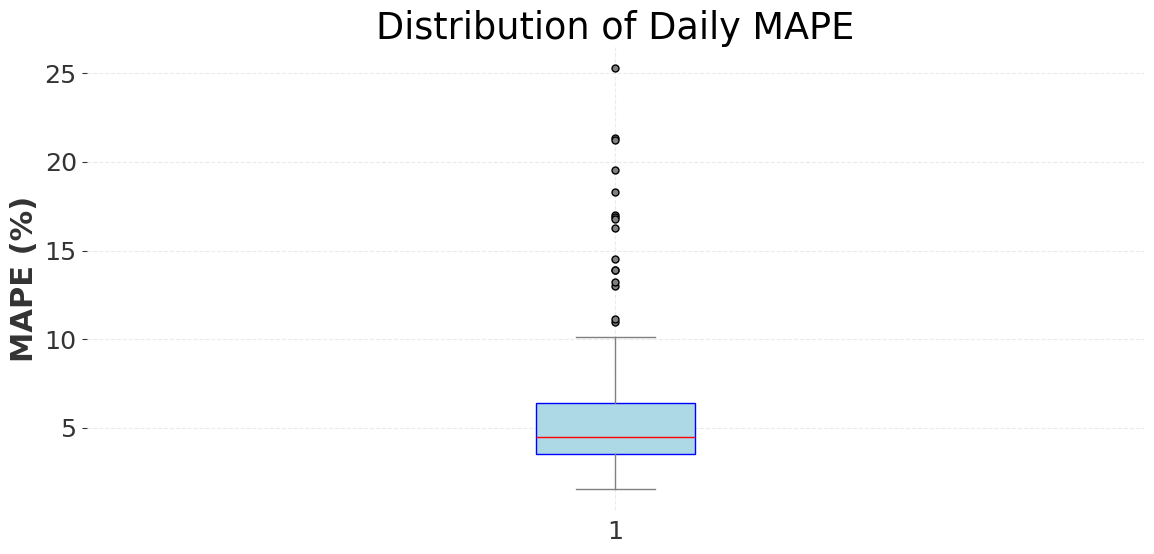

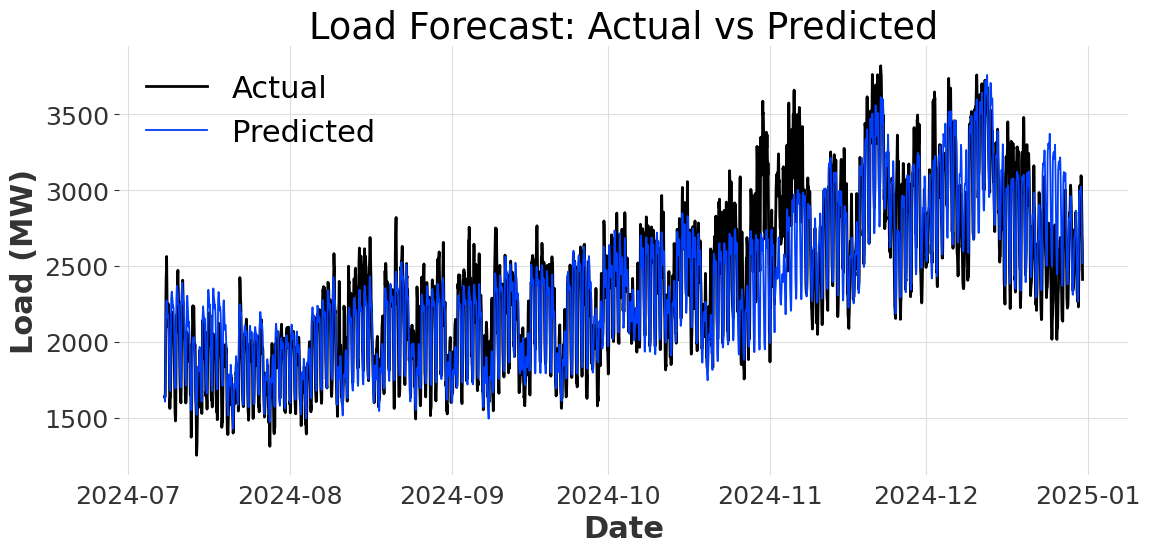

Forecast from 2024-07-22 00:00 to 2024-07-29 00:00
MAPE: 4.67%
RMSE: 103.08
MAE: 83.66MW
Maximum MAPE: 6.40% on 2024-07-28
Minimum MAPE: 2.91% on 2024-07-23


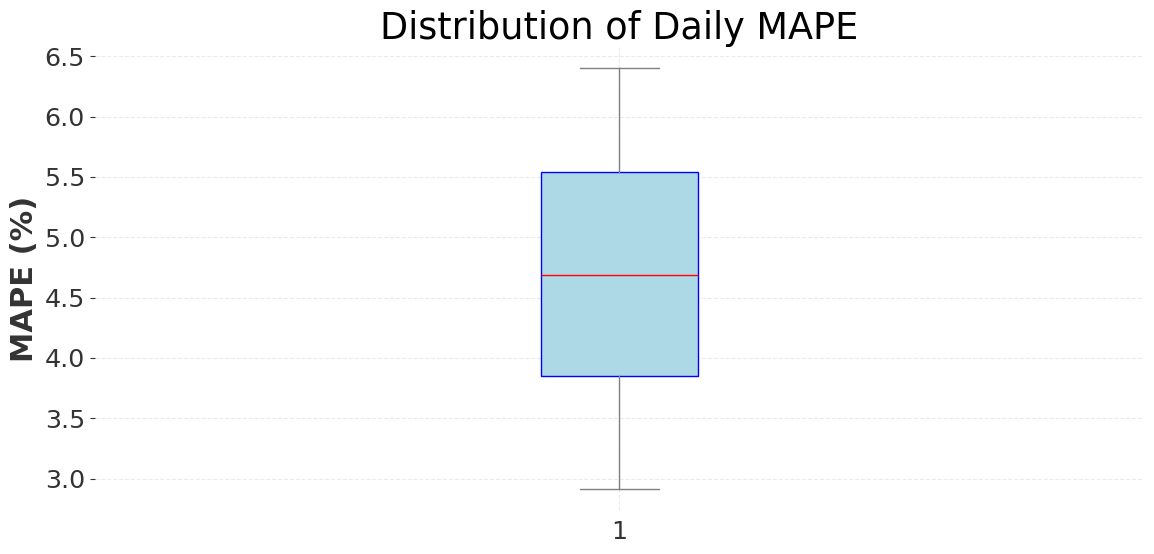

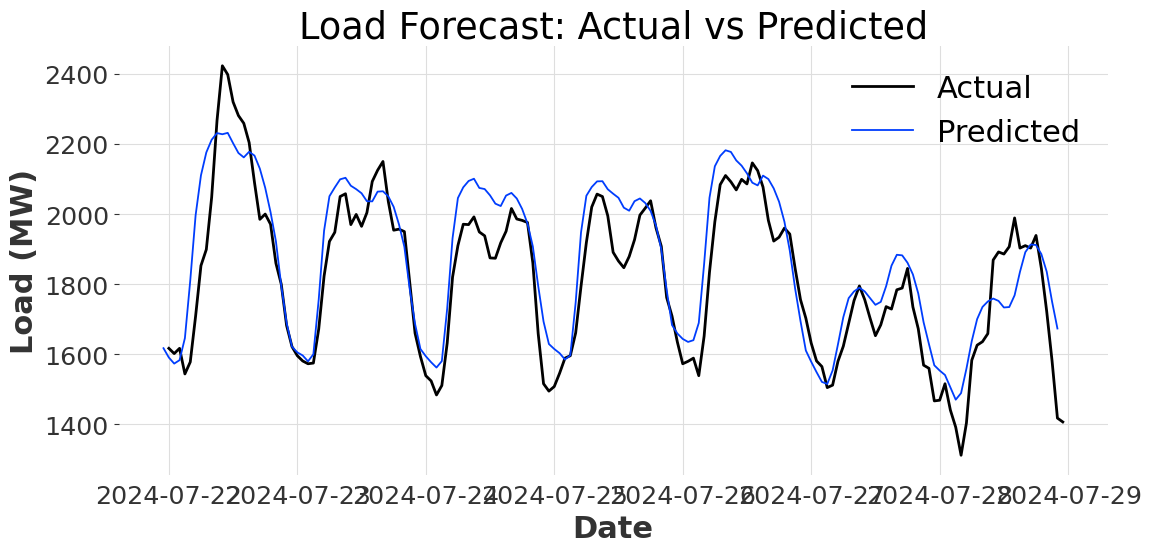

Forecast from 2024-10-14 00:00 to 2024-10-21 00:00
MAPE: 4.15%
RMSE: 124.86
MAE: 97.03MW
Maximum MAPE: 6.47% on 2024-10-20
Minimum MAPE: 2.21% on 2024-10-18


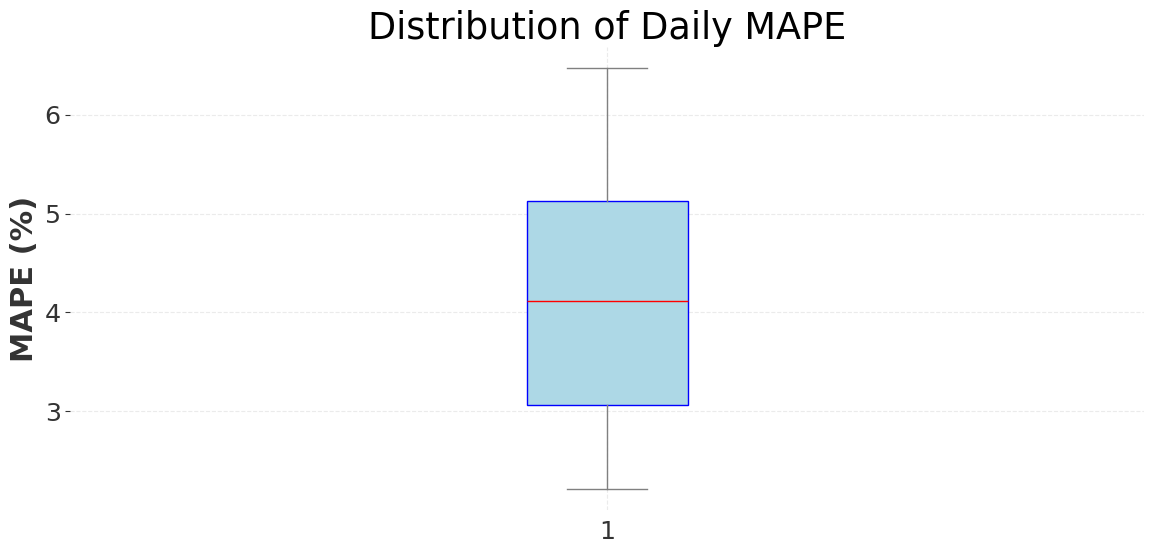

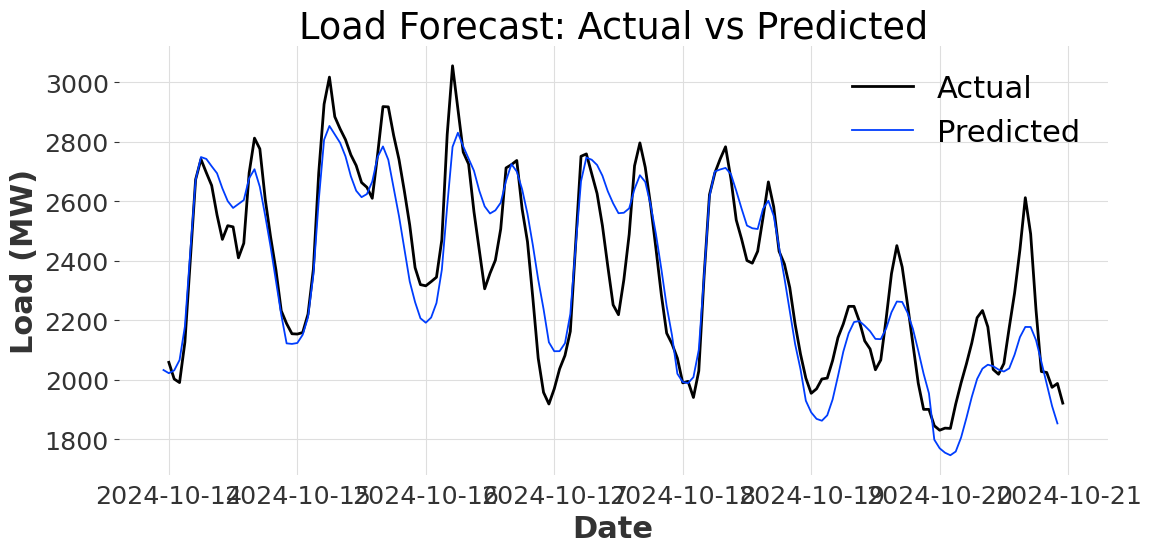

Forecast from 2024-10-28 00:00 to 2024-11-04 00:00
MAPE: 14.70%
RMSE: 495.72
MAE: 430.91MW
Maximum MAPE: 21.38% on 2024-10-30
Minimum MAPE: 4.26% on 2024-11-01


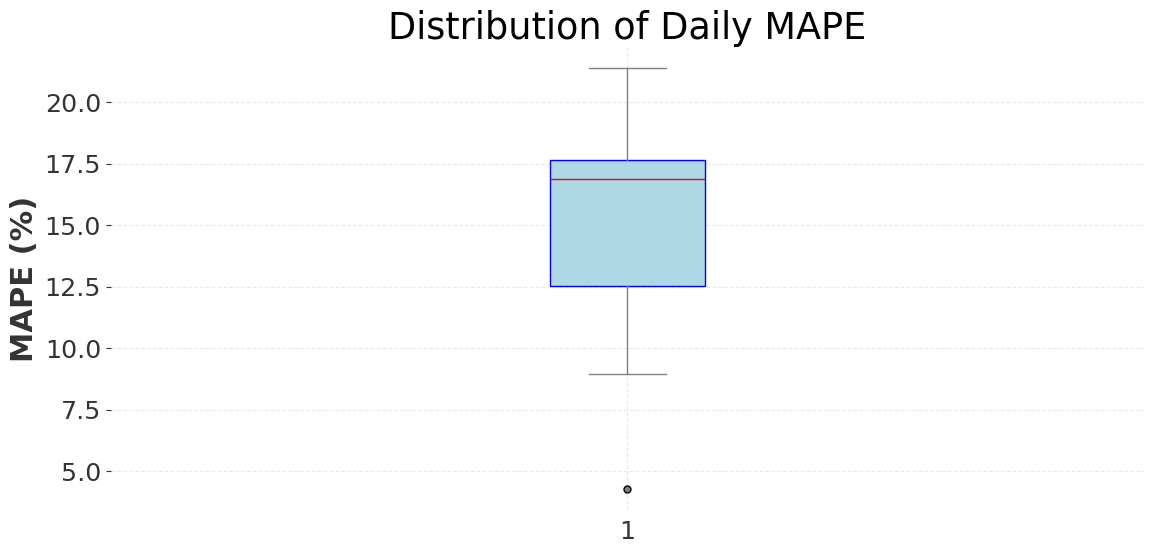

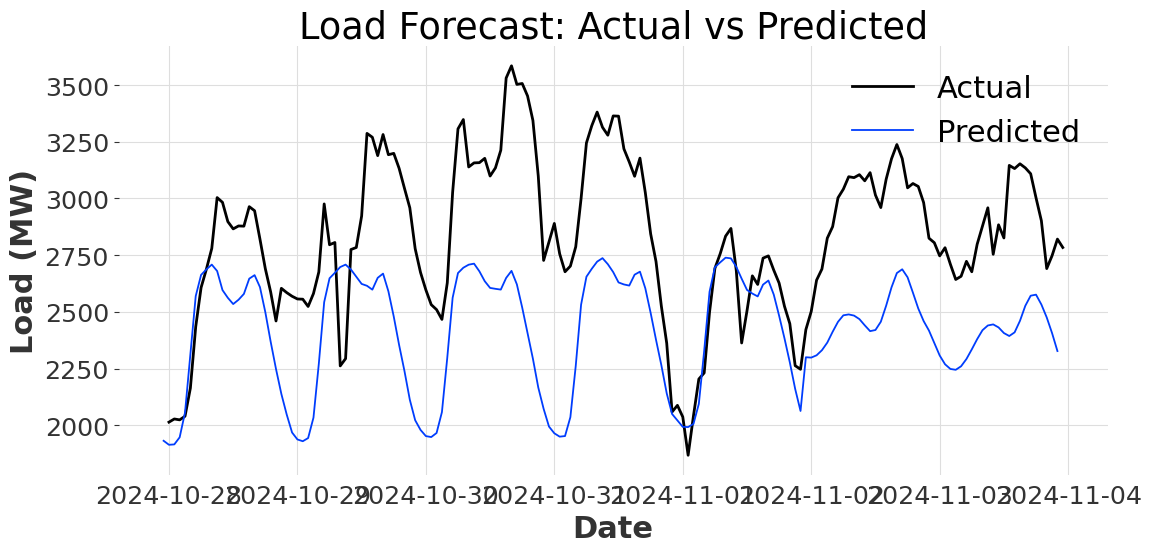

Forecast from 2024-12-02 00:00 to 2024-12-09 00:00
MAPE: 6.04%
RMSE: 215.70
MAE: 177.72MW
Maximum MAPE: 11.17% on 2024-12-08
Minimum MAPE: 2.77% on 2024-12-03


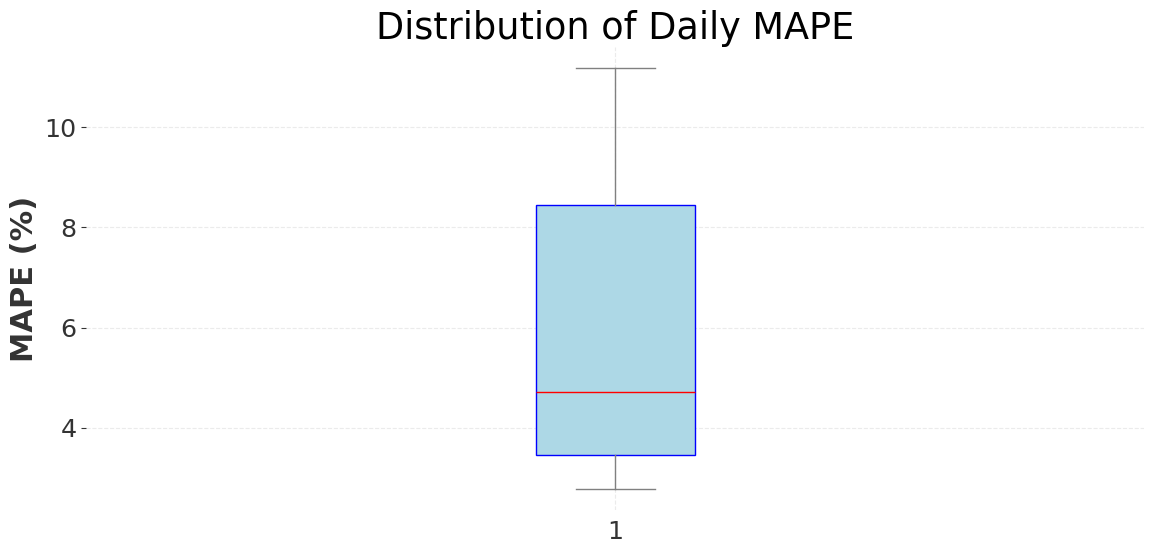

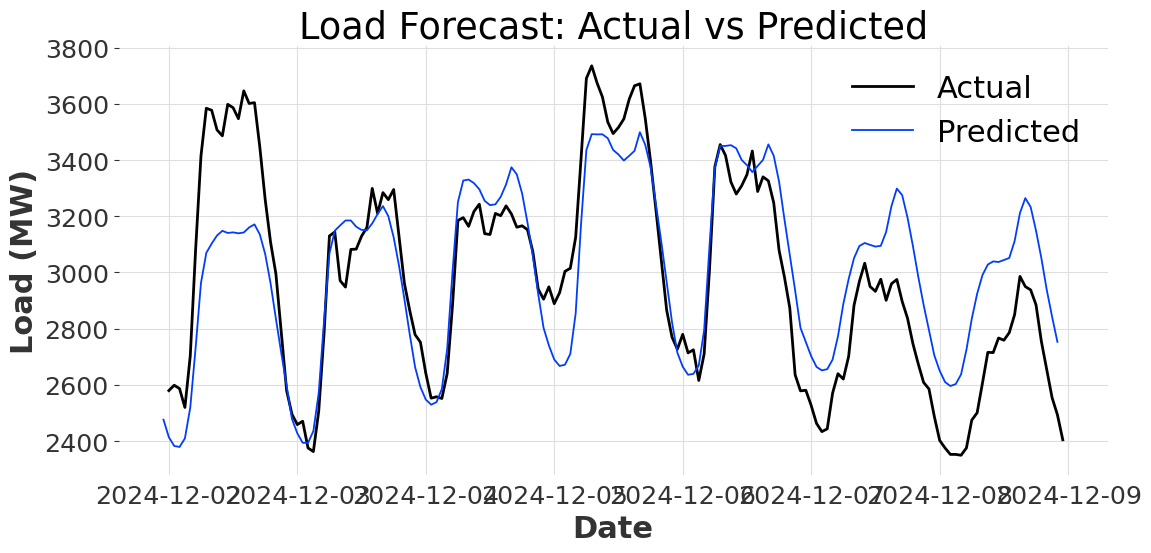

Forecast from 2024-12-23 00:00 to 2024-12-30 00:00
MAPE: 11.37%
RMSE: 342.83
MAE: 280.65MW
Maximum MAPE: 22.80% on 2024-12-25
Minimum MAPE: 3.55% on 2024-12-29


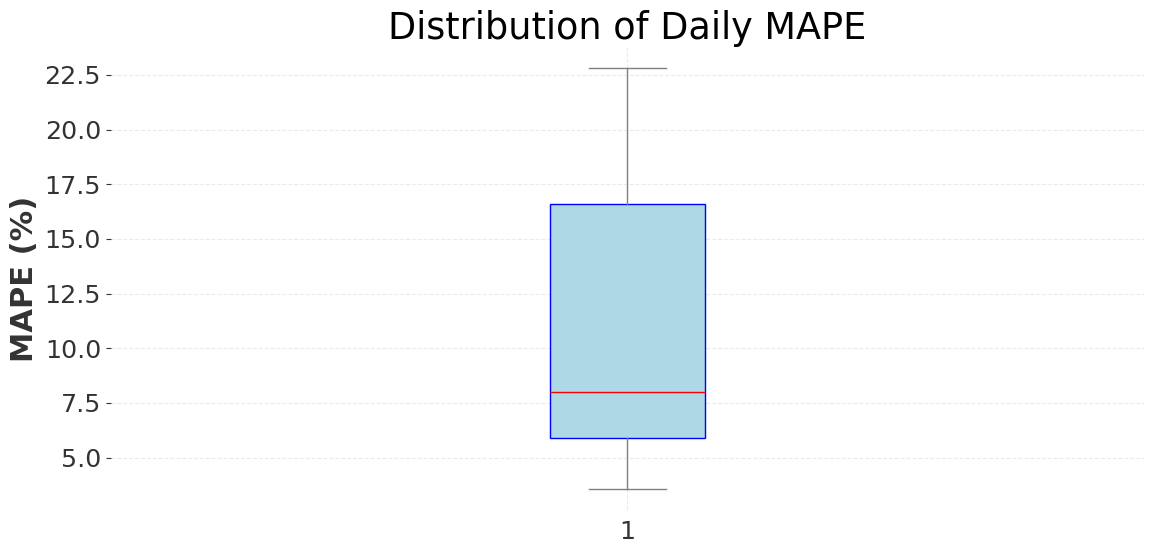

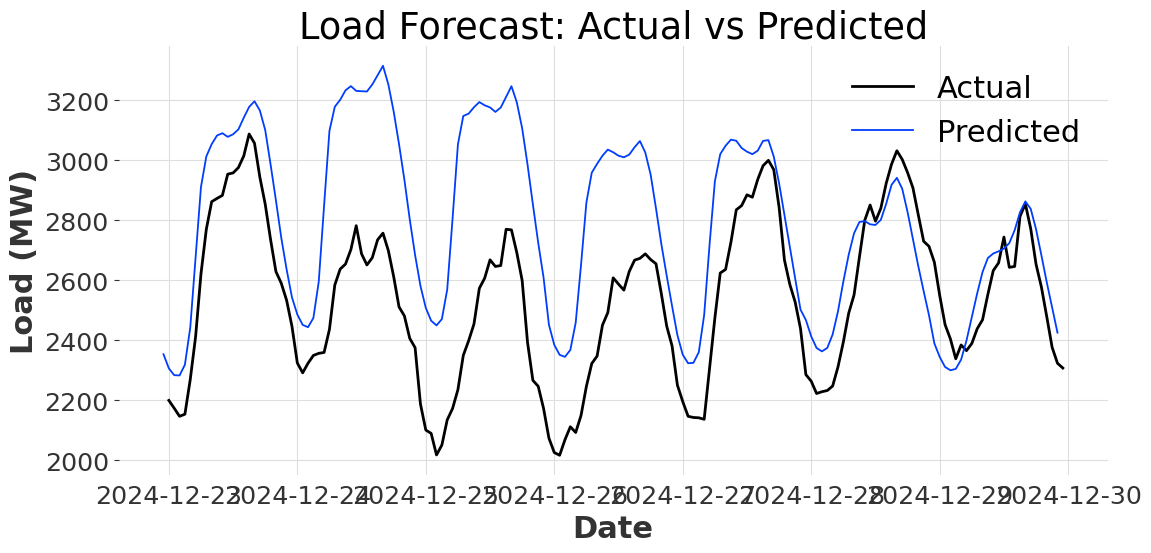

In [13]:
forecast_windows = [(pd.Timestamp('2024-07-08'), pd.Timestamp('2024-12-31')),
                    (pd.Timestamp('2024-07-22'), pd.Timestamp('2024-07-29')),
                    (pd.Timestamp('2024-10-14'), pd.Timestamp('2024-10-21')),
                    (pd.Timestamp('2024-10-28'), pd.Timestamp('2024-11-04')),
                    (pd.Timestamp('2024-12-02'), pd.Timestamp('2024-12-09')),
                    (pd.Timestamp('2024-12-23'), pd.Timestamp('2024-12-30'))]

make_forecast(RFR, test_series, test_covariates_past, test_covariates_future, forecast_windows)

### Evaluate RFR model without covariates

Forecast from 2024-07-08 00:00 to 2024-12-31 00:00
MAPE: 16.09%
RMSE: 562.65
MAE: 422.03MW
Maximum MAPE: 37.41% on 2024-12-12
Minimum MAPE: 4.34% on 2024-09-21


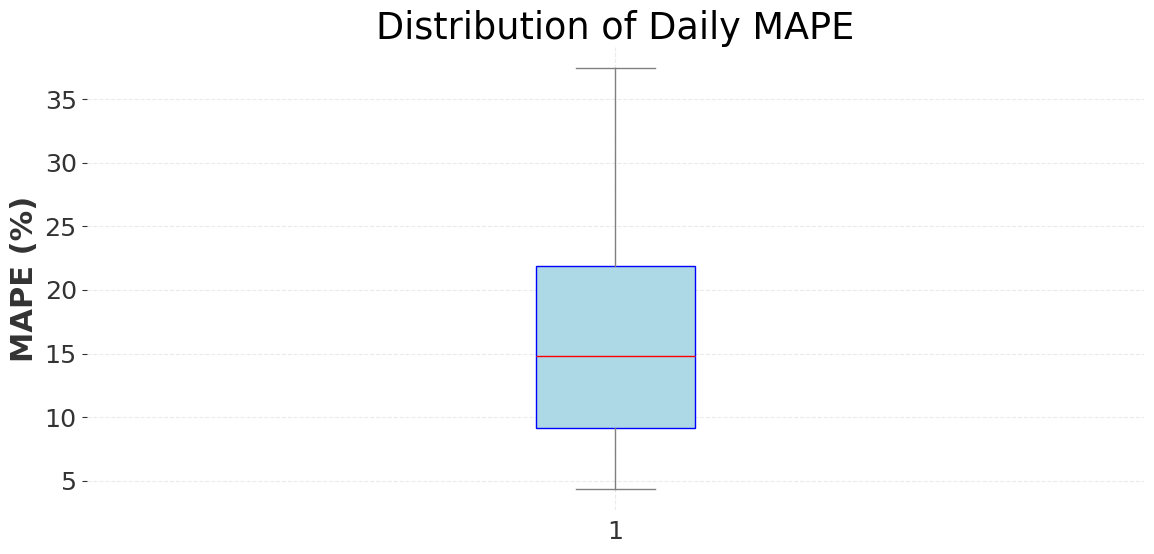

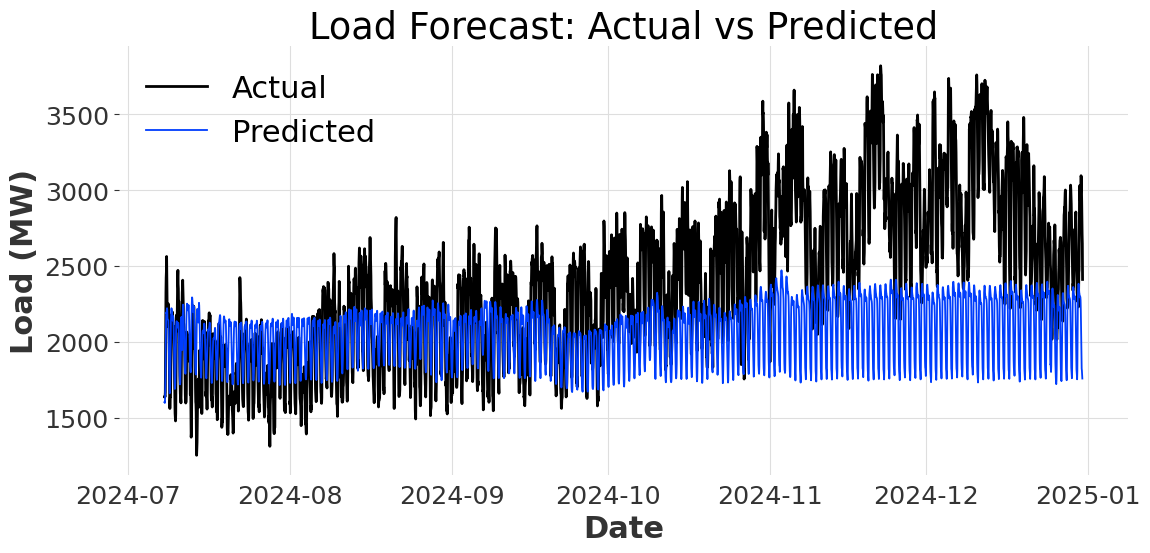

Forecast from 2024-07-22 00:00 to 2024-07-29 00:00
MAPE: 10.83%
RMSE: 235.91
MAE: 185.50MW
Maximum MAPE: 19.07% on 2024-07-27
Minimum MAPE: 6.12% on 2024-07-26


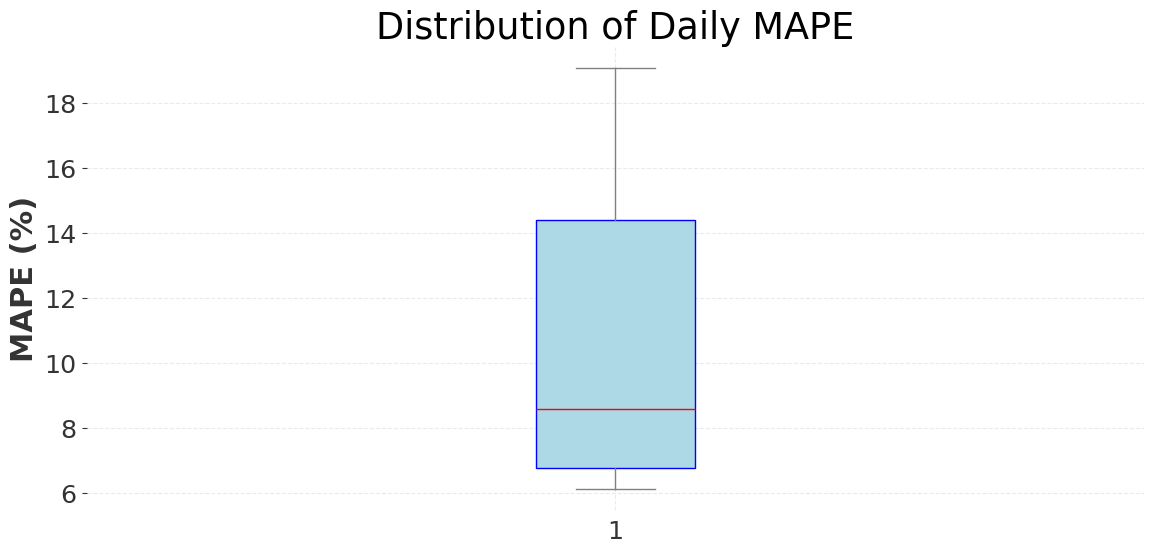

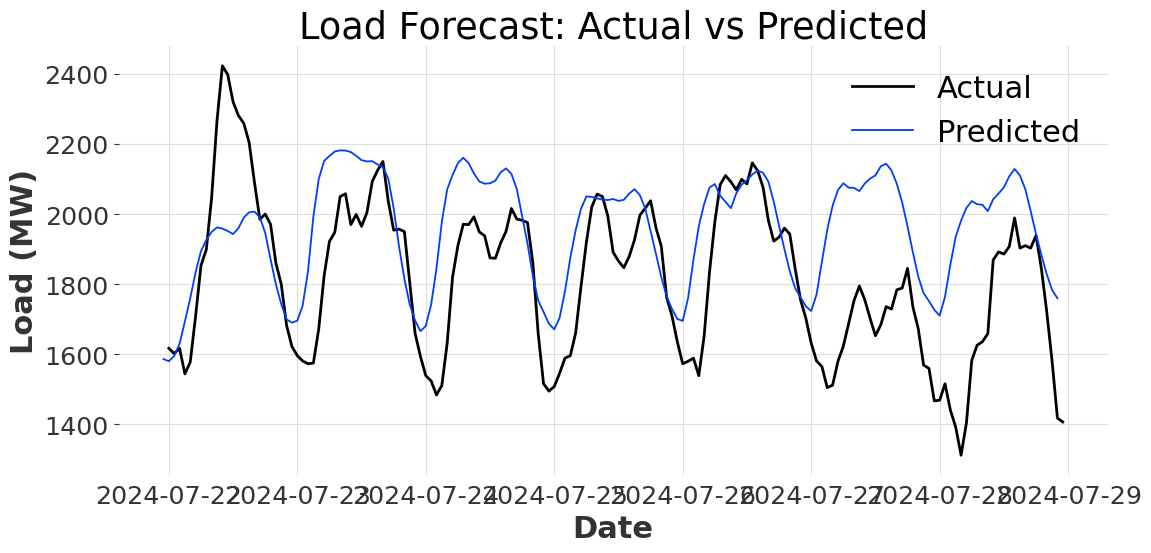

Forecast from 2024-10-14 00:00 to 2024-10-21 00:00
MAPE: 7.94%
RMSE: 236.00
MAE: 185.40MW
Maximum MAPE: 12.18% on 2024-10-19
Minimum MAPE: 4.40% on 2024-10-14


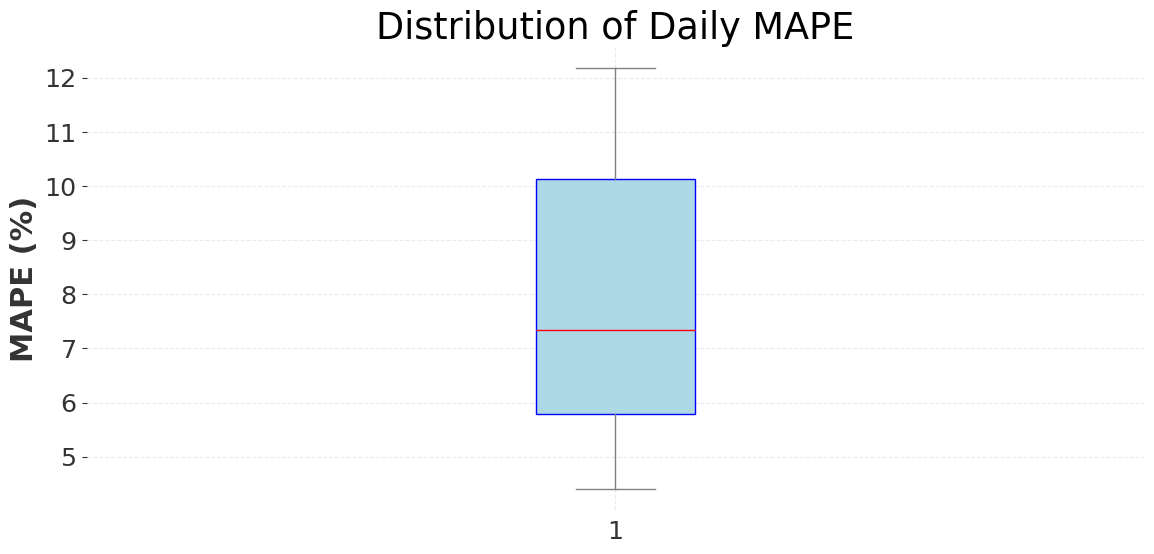

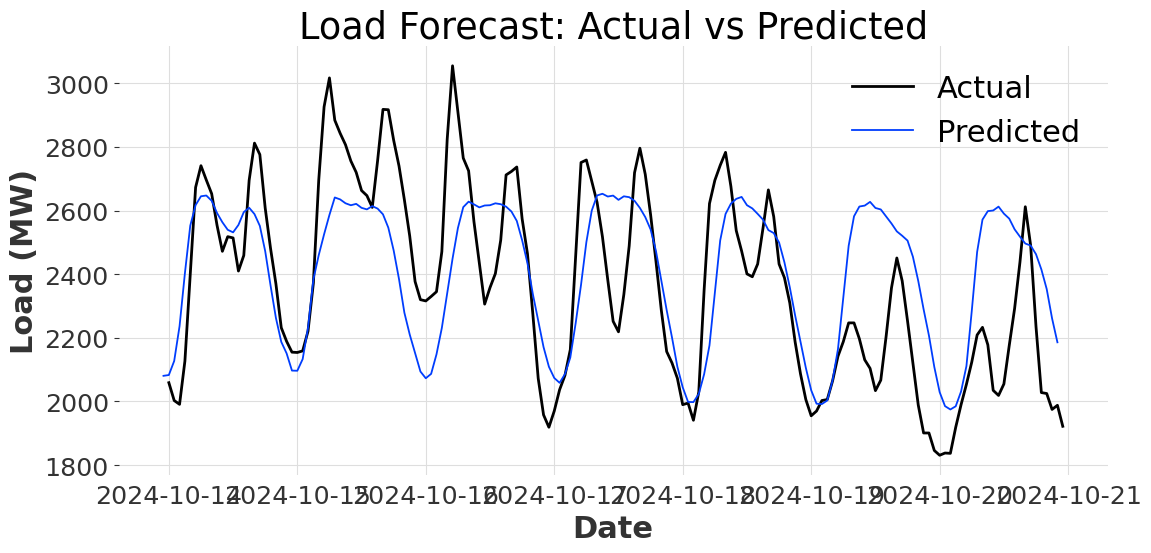

Forecast from 2024-10-28 00:00 to 2024-11-04 00:00
MAPE: 24.05%
RMSE: 751.30
MAE: 697.54MW
Maximum MAPE: 30.59% on 2024-11-02
Minimum MAPE: 13.09% on 2024-10-28


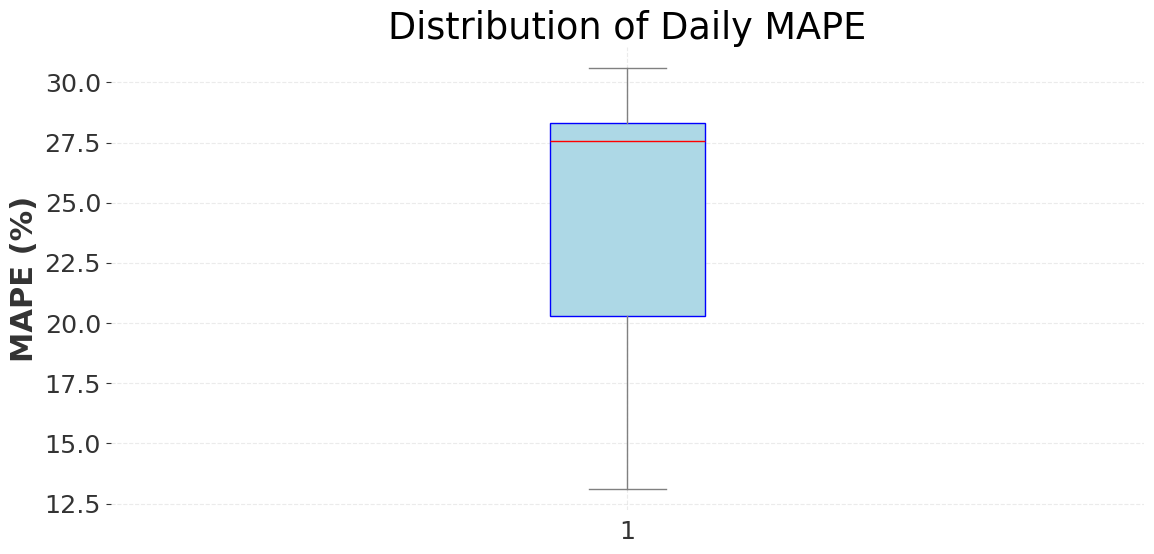

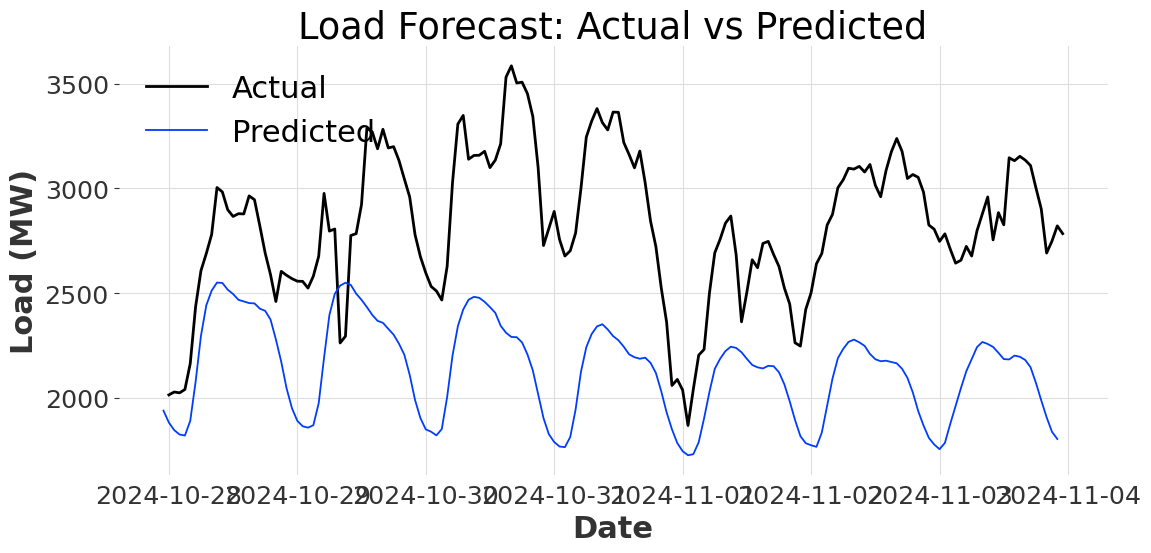

Forecast from 2024-12-02 00:00 to 2024-12-09 00:00
MAPE: 9.30%
RMSE: 333.28
MAE: 282.20MW
Maximum MAPE: 13.71% on 2024-12-08
Minimum MAPE: 6.15% on 2024-12-06


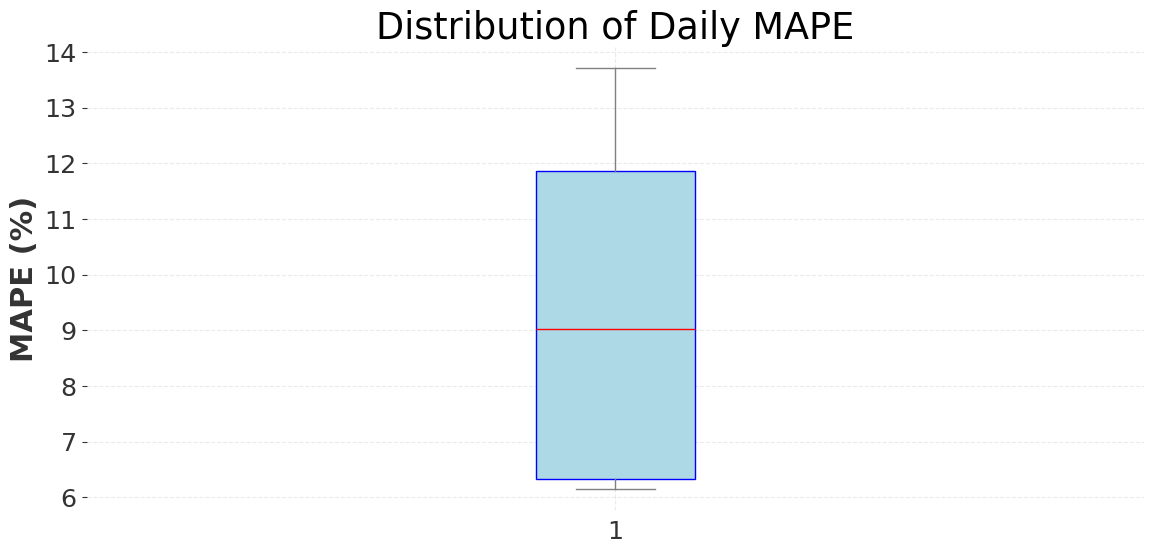

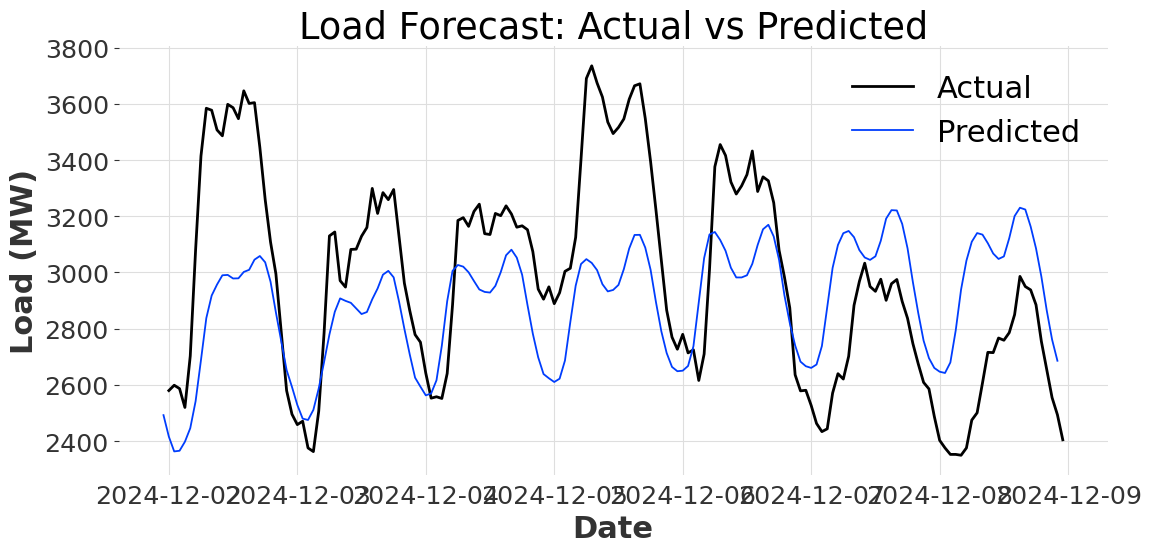

Forecast from 2024-12-23 00:00 to 2024-12-30 00:00
MAPE: 8.76%
RMSE: 246.83
MAE: 211.98MW
Maximum MAPE: 12.85% on 2024-12-26
Minimum MAPE: 3.47% on 2024-12-23


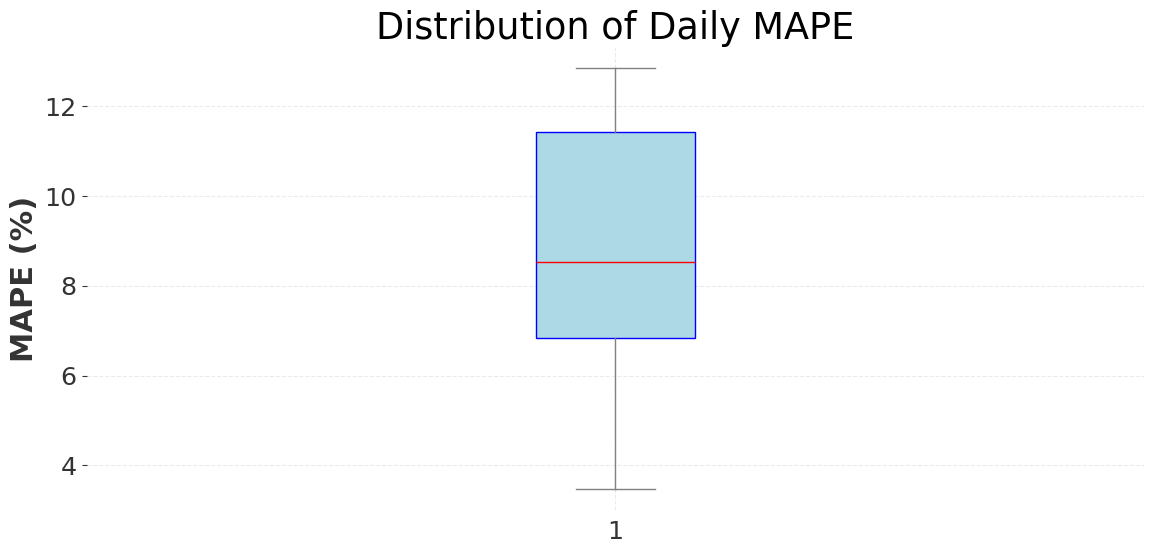

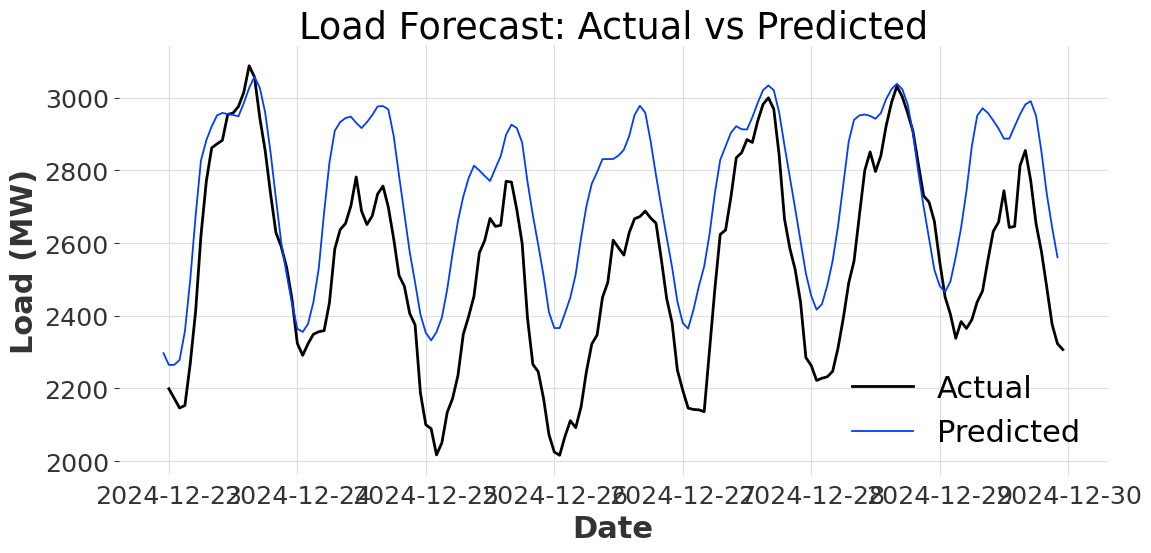

In [14]:
make_forecast(model=RFR_no_cov, test_series=test_series, forecast_windows=forecast_windows)

In [15]:
# Filter rows where the date is between Dec 20 and Dec 30 (inclusive)
dec_range = data[(data.index.month == 12) & (data.index.day >= 23) & (data.index.day <= 26)]

# Group by year and calculate the mean temperature
avg_temp_by_year = dec_range.groupby(dec_range.index.year)['Temperature'].mean()

print(avg_temp_by_year)

Time
2015    6.483194
2016    5.476521
2017    7.027632
2018    1.514933
2019    4.247201
2020    1.717786
2021   -3.320965
2022    1.819656
2023    2.655069
2024    4.861917
Name: Temperature, dtype: float64
